**20164245 Hong Jin**

[Apply K-means algorithm to both image value and its spatial domain]

For a given input image (either gray or color), apply a K-means algorithm that is designed to take into consideration of both the image intensity and its spatial domain with varying parameters: the number of clusters and the trade-off between the intensity energy and the spatial energy.

The objective function is given by:

$$\sum_k \sum_\{ x \in I(k) \} [ \| f(x) - m_k \|^2 + a * \| x - c_k \|^2 ]$$

where I(k) denotes the index set of x that belongs to cluster k, m_k denotes the centroid of image intensity for cluster k, c_k denotes the centroid of spatial location for cluster k, and a determines the importance between the image intensity and the spatial relation.

- Visualize the clustering results with varying k and a using the centroid color m_k for each cluster k. 

- Visualize the energy curve for both the intensity energy and the spatial energy.

# Initial array

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import math

image = cv2.imread("keyring.jpg")
im_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = im_color.shape[:2]
pix_num = height * width

x = np.zeros((height, width), dtype = float)
y = np.zeros((height, width), dtype = float)

r = im_color[:,:,0]
g = im_color[:,:,1]
b = im_color[:,:,2]

g = np.zeros((height, width), dtype = float)
b = np.zeros((height, width), dtype = float)

for i in range(height):
    for j in range(width):
        x[i][j] = i
        y[i][j] = j

im_label = np.zeros((height, width), dtype = int)

E1 = []
E2 = []
E3 = []

# Initial Image

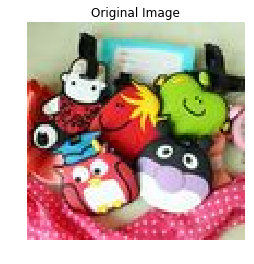

In [2]:
plt.title('Original Image')
plt.imshow(im_color)
plt.axis('off')
plt.show()

# Nomalization

In [3]:
def normalize(x,y):
    
    dx = np.zeros((height, width), dtype=float)
    dy = np.zeros((height, width), dtype=float)
    
    for i in range(height):
        for j in range(width):
            dx[i,j] = i/height
            dy[i,j] = j/width
    
    return dx, dy

# Whitening

$g(x) = \frac{f(x)-\mu}{\sigma}, \mu = \frac{\sum{f(x_i)}}{|\Omega|}, 
\sigma^2 = \frac{\sum{(f(x_i) - \mu)^2}}{\Omega}$

In [4]:
def whitening(data):
    mu = [0,0,0]
    sigma = [0,0,0]
    data_whitening = im_color.copy()
    
    r_mu = np.sum(data[:,:,0]) / pix_num
    g_mu = np.sum(data[:,:,1]) / pix_num
    b_mu = np.sum(data[:,:,2]) / pix_num
    mu = [r_mu, g_mu, b_mu]
    
    r_std = math.sqrt((np.sum((data[:,:,0] - r_mu)**2)) / pix_num)
    g_std = math.sqrt((np.sum((data[:,:,1] - g_mu)**2)) / pix_num)
    b_std = math.sqrt((np.sum((data[:,:,2] - b_mu)**2)) / pix_num)
    sigma = [r_std, g_std, b_std]

    data_whitening[:,:,0] = (data[:,:,0] - r_mu) / r_std
    data_whitening[:,:,1] = (data[:,:,1] - g_mu) / g_std
    data_whitening[:,:,2] = (data[:,:,2] - b_mu) / b_std
    
    return data_whitening, mu, sigma

# Compute distance based on L2-norm square

$${||x-y||_{2}}^2 = x^2 + y^2 $$

In [5]:
def distance(x,y):
    d = (x - y) ** 2
    s = np.sum(d)
    
    return s

# Initialize Label

initialize all images with random label

In [6]:
def initialLabel(cluster_num):
    for i in range(height):
        for j in range(width):
            initial_num = random.randrange(0, cluster_num)
            im_label[i][j] = initial_num
    
    return im_label

# Initialize Centroid

In [7]:
def initialCentroid(im_average_x, im_average_y, im_average,cluster_num, im_label, im_count):
    for i in range(height):
        for j in range(width):
            im_average_x[im_label[i,j]] += x[i][j]
            im_average_y[im_label[i,j]] += y[i][j]
            im_average[im_label[i,j]] += im_color[i,j]
            im_count[im_label[i,j]] += 1

    
    for i in range(cluster_num):
        im_average_x[i] /= im_count[i]
        im_average_y[i] /= im_count[i]
        im_average[i] /= im_count[i]
    
    return im_average_x, im_average_y, im_average, im_count

# Plot the Final Image

In [8]:
def plot_average(im_average, cluster_num, mean, std):
    f1 = plt.figure(1)
    new_image = im_color.copy()
    
    for i in range(height) :
        for j in range(width):
            new_image[i,j] = im_average[im_label[i,j]] #* std + mean

    
    plt.title('Final Image')
    plt.imshow(new_image)
    plt.axis('off')
    plt.show()

# Clustering

In [9]:
def clustering(im_label, cluster_num, im_average_x, im_average_y, im_average, alpha):
    dist = 0
    label = 0

    for i in range(height):
        for j in range(width): 
            mins = 1000000000
            for k in range(cluster_num): 
                nx = x[i][j]
                ny = y[i][j]
                ax = im_color[i,j]
                ay = im_average[k]
                cx = im_average_x[k]
                cy = im_average_y[k]
                dist = distance(nx, cx) + distance(ny, cy)+ alpha*distance(ax,ay)
                if dist < mins:
                    mins = dist
                    label = k
            im_label[i][j] = label
    
    return im_label

# Compute Centroid

In [10]:
def computeCentroid(cluster_num, im_label):
    num = np.zeros(cluster_num, dtype = int)
    c = np.zeros((cluster_num, 3), dtype = float)
    cx = np.zeros(cluster_num, dtype = float)
    cy = np.zeros(cluster_num, dtype = float)

    for i in range(height):
        for j in range(width):
            cx[im_label[i][j]] += x[i][j]
            cy[im_label[i][j]] += y[i][j]
            c[im_label[i][j]] += im_color[i,j]
            num[im_label[i][j]] += 1 
            
    for k in range(cluster_num):
        if num[k] != 0:
            cx[k] /= num[k]
            cy[k] /= num[k]
            c[k] /= num[k]
        
    return cx, cy, c

# Compute Energy

$E=\frac{1}{n} \sum_{x \in \Omega} \| f(x) - m_c \|^2,$

where $\Omega$ denotes the image domain and the number of pixels $| \Omega |$ is $n$, and $m_c$ denotes the centroid for cluster $c$ that is the cluster label of $f(x)$.

In [11]:
def computeEnergy(im_label, cluster_num, im_average_x, im_average_y,im_average):
    total_sum1 = 0
    total_sum2 = 0
    total_sum = 0
    num = 0
    for i in range(height):
        for j in range(width):
            total_sum1 += distance(x[i][j], im_average_x[im_label[i][j]])
            total_sum1 += distance(y[i][j], im_average_y[im_label[i][j]])
            total_sum2 += distance(im_color[i,j], im_average[im_label[i,j]])
            num += 1
    
    total_sum1 /= num
    total_sum2 /= num
    total_sum = total_sum1+total_sum2
    
    return total_sum1, total_sum2, total_sum

# Initialize Cluster

In [12]:
def initialCluster(cluster_num):
    im_average_x = np.zeros(cluster_num, dtype=float)
    im_average_y = np.zeros(cluster_num, dtype=float)
    im_average = np.zeros((cluster_num,3), dtype=float)
    im_count = np.zeros(cluster_num, dtype=int)

    im_label = initialLabel(cluster_num)

    im_average_x, im_average_y, im_average, im_count = initialCentroid(im_average_x, im_average_y, im_average, cluster_num, im_label, im_count)
    
    E1.clear()
    E2.clear()
    E3.clear()

    return im_average_x, im_average_y, im_average, im_count, im_label

# Clustering until no change

no change means energy is maintained

In [13]:
def iteration(cluster_num, alpha, im_average_x, im_average_y, im_average, im_count, im_label, mean, std):
    iter_num = 0
    
    while True:
        im_label = clustering(im_label, cluster_num, im_average_x, im_average_y, im_average, alpha)
        im_average_x, im_average_y,im_average  = computeCentroid(cluster_num,im_label)
        
        a,b,c = computeEnergy(im_label, cluster_num, im_average_x, im_average_y, im_average)
        E1.append(a)
        E2.append(b)
        E3.append(c)
        
        if iter_num > 0:
            if E3[iter_num-1] == E3[iter_num]:
                break
        iter_num += 1

    plot_average(im_average,cluster_num,mean, std)
    
    return iter_num

# Energy graph per each iteration

In [14]:
def drawEnergy(iter_num, name, energy):
    plt.figure(3)
    x_range = np.arange(iter_num+1)
    
    plt.plot(x_range, energy, "g")
    plt.title(str(name) + " Energy")
    plt.grid(True)

    plt.show()

# Normalize data

In [15]:
mean = []
std = []
# x,y  = normalize(x,y)
# im_color, mean, std = whitening(im_color)

# $K = 7, \alpha = 0.1$

## Final average image

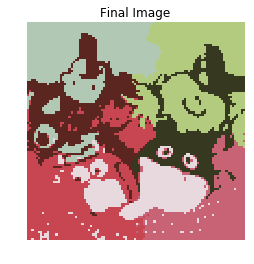

In [16]:
im_average_x, im_average_y,im_average, im_count,im_label = initialCluster(7)
iter_num = iteration(7,0.1,im_average_x, im_average_y, im_average, im_count, im_label, mean, std)

## Energy graphs

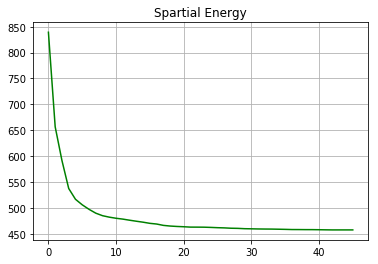

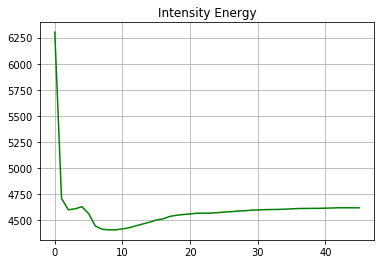

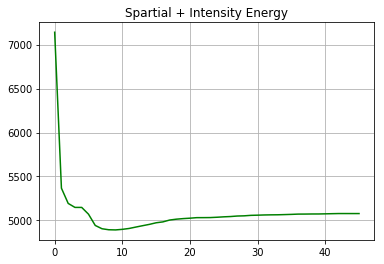

In [17]:
drawEnergy(iter_num, "Spartial", E1)
drawEnergy(iter_num, "Intensity", E2)
drawEnergy(iter_num, "Spartial + Intensity", E3)

# $K = 7, \alpha = 0.7 $

## Final average image

In [ ]:
im_average_x, im_average_y,im_average, im_count,im_label = initialCluster(7)
iter_num = iteration(7,0.7,im_average_x, im_average_y, im_average, im_count, im_label, mean ,std)

# Energy graph

In [ ]:
drawEnergy(iter_num, "Spartial", E1)
drawEnergy(iter_num, "Intensity", E2)
drawEnergy(iter_num, "Spartial + Intensity", E3)

# $K = 12, \alpha = 0.1$

## Final average Image

In [ ]:
im_average_x, im_average_y,im_average, im_count,im_label = initialCluster(12)
iter_num = iteration(12,0.1,im_average_x, im_average_y, im_average, im_count, im_label, mean, std)

## Energy graph

In [ ]:
drawEnergy(iter_num, "Spartial", E1)
drawEnergy(iter_num, "Intensity", E2)
drawEnergy(iter_num, "Spartial + Intensity", E3)

# $k=12, \alpha = 0.7$

## Final average Image

In [ ]:
im_average_x, im_average_y,im_average, im_count,im_label = initialCluster(12)
iter_num = iteration(12,0.7,im_average_x, im_average_y, im_average, im_count, im_label, mean, std)

## Energy graph

In [ ]:
drawEnergy(iter_num, "Spartial", E1)
drawEnergy(iter_num, "Intensity", E2)
drawEnergy(iter_num, "Spartial + Intensity", E3)